# Preparing the environment

In [1]:
from algorithms import UCB, ImprovedUCB, Glouton, EpsilonGlouton, OptimalPlayer
from casino import Casino
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [2]:
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True

> **Note** :
> The experiments done in this notebook may not be **reproducible** as we do not specify a fixed seed for
> `numpy.random`.

# How does $\epsilon$ affect The Eplison-Greedy algorithm

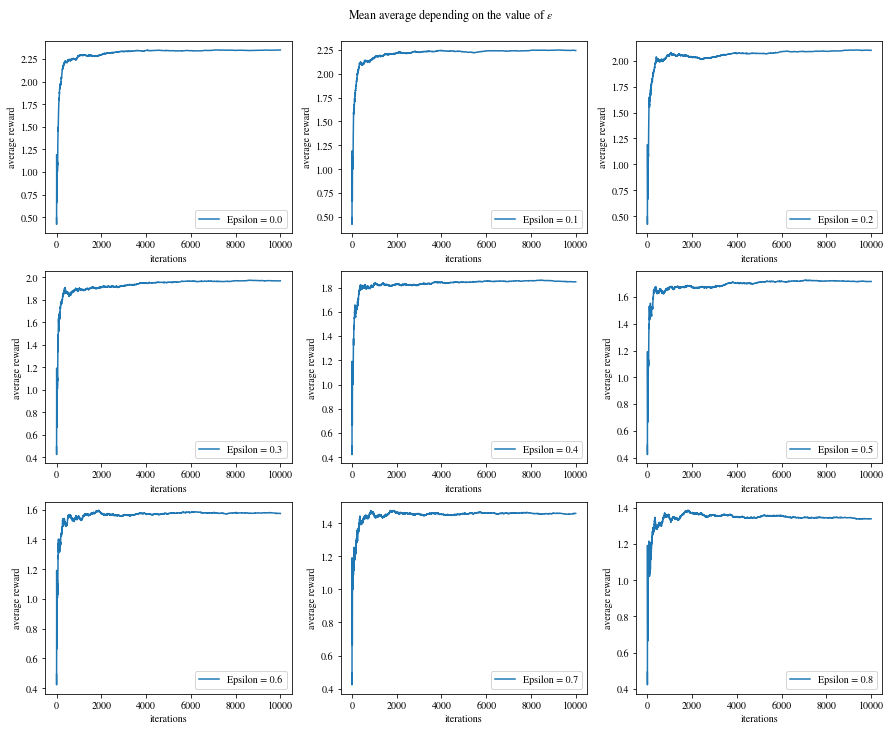

In [15]:
casino = Casino(nb=50)
epsilon_values = np.arange(0.0, 0.9, 0.1)

fig = plt.figure(figsize=[15, 12])
params = {
    "initial_credit": 10000,
    "test_iterations": 1,
}

for i, epsilon in enumerate(epsilon_values):
    epsilon_glouton = EpsilonGlouton(casino, **params, epsilon=epsilon)
    epsilon_glouton.do_epsilon_glouton()
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(epsilon_glouton.avg_reward, label="Epsilon = %.1f" % epsilon)
    ax.legend()
    ax.set_xlabel("iterations", fontsize=10)
    ax.set_ylabel("average reward", fontsize=10)

fig.suptitle("Mean average depending on the value of $\epsilon$", y=0.92)
plt.savefig("images/figure_1.jpg", dpi=400)

It appears that small values of $\epsilon$ get the best performance. This is probably because the algorithms lears very fast which machine is the best which makes exploration a waste of time.

# Analyzing the UCB algorithm

In [4]:
nb_machines = 10
initial_credit = 5000

casino = Casino(nb=nb_machines)
ucb = UCB(casino, initial_credit=initial_credit, confidence=1)

Let's get the best confidence value for the UCB. We can do that by trying different values of confidence between 0.1 and 2.0 each one multiple times, calculate the mean and draw the corresponding curve. We will repeat UCB on each confidence value 20 times before calculating the mean so that the value does not get biased as the casino machines use probabilities to return rewards.

In [5]:
confidence_values = np.arange(0.1, 2.0, 0.1)
total_rewards = []
repetition = 20
with tqdm(
    total=len(confidence_values) * repetition, desc="Testing values"
) as pbar:
    for c in range(len(confidence_values)):
        ucb.confidence = confidence_values[c]
        reward = 0.0
        for i in range(repetition):
            reward += ucb.do_ucb()  # automatically initializes environment at each call
            pbar.update(1)
        total_rewards.append(reward / repetition)

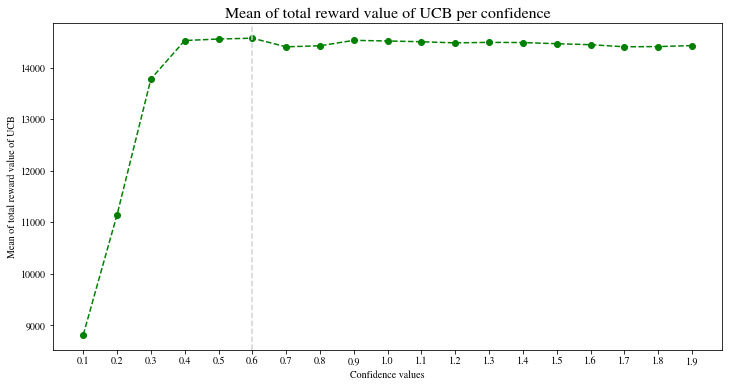

In [6]:
plt.figure(figsize=(12, 6))
plt.ylabel("Mean of total reward value of UCB")
plt.xlabel("Confidence values")
plt.title("Mean of total reward value of UCB per confidence", fontsize=16)
plt.plot(confidence_values, total_rewards, marker="o", linestyle="--", color="g", label="mean total reward")
plt.axvline(
    x=confidence_values[np.argmax(total_rewards)], linestyle="--", color="lightgrey", label="best confidence"
)
plt.xticks(confidence_values)
fig.tight_layout()
plt.savefig("images/figure_2.jpg", dpi=400)

The curve shows that the value of confidence that gave the maximum mean total reward is 0.7.
> **Note**: this value depends on the random payoffs of the machines. It may sometimes be different.

## Comparing UCB With Optimal player
The optimal player does not necessarily get the best reward. But it is likely to do so because it chooses the machine with the best payoff. If it is lucky, than the normal distribution of randomness should help get the best reward.

In [12]:
# UCB rewards and UCB cumulative rewards
ucb = UCB(casino, initial_credit, confidence=0.6)
ucb.do_ucb()

# Optimal rewards and cumulative optimal rewards
optimal = OptimalPlayer(casino, initial_credit)
optimal.do_optimal()

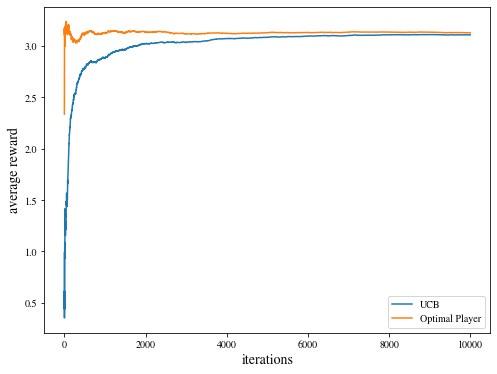

In [13]:
plt.figure(figsize=[8, 6])
plt.plot(ucb.avg_reward, label="UCB")
plt.plot(optimal.avg_reward, label="Optimal Player")

plt.xlabel("iterations", fontsize=14)
plt.ylabel("average reward", fontsize=14)
plt.legend()
plt.savefig("images/figure_3.jpg", dpi=400)

# Improved version of the UCB algorithm

An improved version of the UCB method has been implemented in the `ImprovedUCB` class. It is inspired by the work in [this paper](http://personal.unileoben.ac.at/rortner/Pubs/UCBRev.pdf). Let's compare its performance with the rest of the algorithms. We will keep a confidence of 1 for this experiment.

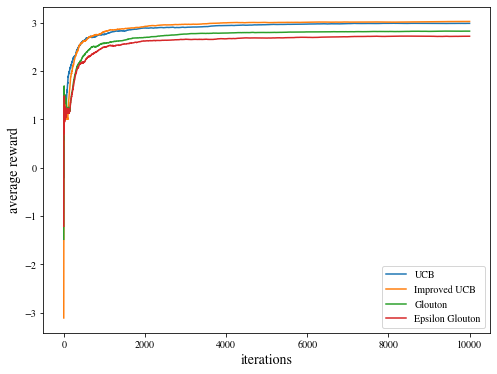

In [16]:
from casino import Casino
from algorithms import Glouton, EpsilonGlouton, UCB, ImprovedUCB


initial_credit = 10000
test_iterations = 3


casino = Casino(nb=50)
ucb = UCB(casino, initial_credit=initial_credit)
improved_ucb = ImprovedUCB(casino, initial_credit=initial_credit)
glouton = Glouton(casino, initial_credit=initial_credit, test_iterations=test_iterations)
epsilon_glouton = EpsilonGlouton(casino, initial_credit=initial_credit, test_iterations=test_iterations, epsilon=0.1)

ucb.do_ucb()
glouton.do_glouton()
epsilon_glouton.do_epsilon_glouton()
improved_ucb.do_improved_ucb()


plt.figure(figsize=[8, 6])
plt.plot(ucb.avg_reward, label="UCB")
plt.plot(improved_ucb.avg_reward, label="Improved UCB")
plt.plot(glouton.avg_reward, label="Glouton")
plt.plot(epsilon_glouton.avg_reward, label="Epsilon Glouton")
plt.xlabel("iterations", fontsize=14)
plt.ylabel("average reward", fontsize=14)
plt.legend()
plt.savefig("images/figure_4.jpg", dpi=400)

The imporved UCB seem to perform a little bit better than the standard UCB. While experimenting, This was not always the case. This may be due to the method in which rewards are generated or to the complexity of the problem.